## Notebook setup

In [1]:
import os
import io
import warnings
import datetime
import numpy as np
import base64

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

# import sys
# sys.path.append('../../')

from openbb_terminal.api import widgets
from openbb_terminal.api import openbb
from openbb_terminal.helper_classes import TerminalStyle

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

WARNING! Breaking changes incoming! Especially avoid using kwargs, since some of them will change.
You can try <link> branch with the latest changes.


In [2]:
try:
    theme = TerminalStyle("light", "light", "light")
except:
    pass
stylesheet = widgets.html_report_stylesheet()
with open("openbb_terminal/reports/OpenBB_reports_logo.png", "rb") as image_file:
    openbb_image_encoded = base64.b64encode(image_file.read())

## Select Ticker

In [3]:
# Parameters that will be replaced when calling this notebook
ticker = "VTI"
report_name = ""

In [4]:
if "." in ticker:
    import sys

    sys.exit(0)

In [5]:
ticker_data = openbb.stocks.load(
    symbol=ticker, start_date=datetime.datetime.now() - datetime.timedelta(days=4 * 30)
)
ticker_data = openbb.stocks.process_candle(df=ticker_data)

author = "Didier Rodrigues Lopes"
report_title = f"ETF RESEARCH REPORT ON {ticker.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily VTI stock with starting period 2022-04-28 for analysis.

('ETF RESEARCH REPORT ON VTI',
 '26 August, 2022',
 '09:47',
 datetime.timezone(datetime.timedelta(seconds=7200), 'CEST'))

In [12]:
info = openbb.etf.summary(name=ticker)
info

'The fund employs an indexing investment approach designed to track the performance of the index, which represents approximately 100% of the investable U.S. stock market and includes large-, mid-, small-, and micro-cap stocks. It invests by sampling the index, meaning that it holds a broadly diversified collection of securities that, in the aggregate, approximates the full index in terms of key characteristics.'

## Data

In [66]:
import pandas as pd

weights = openbb.etf.weights(ticker)
weights_df = pd.DataFrame.from_dict([weights]).T
weights_df.columns = ["Percentage"]

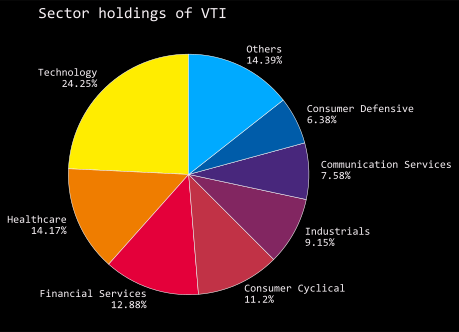

In [69]:
fig, ax = plt.subplots(dpi=150)
openbb.etf.weights(ticker, chart=True, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
weights_chart = f.getvalue().decode("utf-8")

In [48]:
holdings = openbb.etf.holdings(ticker)
holdings

,% Of Etf,Shares
Symbol,,
AAPL,6.06%,455248459
MSFT,5.09%,221437361
AMZN,2.83%,256059983
TSLA,1.90%,26073381
GOOGL,1.71%,178974555
...,...,...
ABNB,0.09%,10190603
MCHP,0.09%,16419619
TRV,0.09%,7103945


## Render the report template to a file

In [74]:
body = ""

img = f'<img src="data:image/png;base64,{openbb_image_encoded.decode()}" alt="OpenBB" style="width:144px;">'
body += widgets.header(
    img,
    author,
    report_date,
    report_time,
    report_timezone,
    f"<b>ETF RESEARCH REPORT:</b> {ticker.upper()}",
)

body += widgets.tablinks(
    [
        "SUMMARY"
    ]
)

htmlcode = widgets.h(3, "Summary")
htmlcode += widgets.p(info)
htmlcode += widgets.row([])

htmlcode += widgets.p("The ETF has the following weights distribution:")

htmlcode += widgets.row([weights_df.to_html()])

htmlcode += widgets.p("And has funds in the following assets:")
htmlcode += widgets.row([holdings.to_html()])

body += widgets.add_tab("SUMMARY", htmlcode)

body += widgets.tab_clickable_evt()

report = widgets.html_report(title=report_name, stylesheet=stylesheet, body=body)

# to save the results
with open(report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)